#Bayesian SN Cosmology

[Rubin et al. 2015](http://arxiv.org/abs/1507.01602) lays out a pretty complete Bayesian model for going from light curve parameters for a large, heterogeneous set of SNe to inferred cosmological parameters. However, it has a couple deficiencies: (1) There's no publicly available code, meaning that the model cannot be modified and improved. (2) The implementation runs slowly (timescale of days). In this hack, we'll start on an open-source package implementing the model and seeing if we can take advantage of aspects of the problem to make it run a whole lot faster.

##Simplistic Model

In [90]:
import scipy
import numpy as np
import sncosmo
import daft
import matplotlib as plt
from astropy.cosmology import FlatLambdaCDM

%matplotlib inline

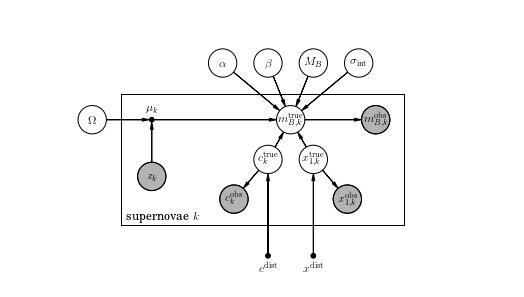

In [127]:
from matplotlib import rc
rc("font", family="serif", size=12)
rc("text", usetex=True)

pgm = daft.PGM([9, 5], origin=[-1.5, 1])
pgm.add_node(daft.Node("alpha", r"${\alpha}$", 2.3, 5))
pgm.add_node(daft.Node("beta", r"${\beta}$", 3.1, 5))
pgm.add_node(daft.Node("Mb", r"$M_{B}$", 3.9, 5))
pgm.add_node(daft.Node("sigma", r"${\sigma_{\mathrm{int}}}$", 4.7, 5))
pgm.add_node(daft.Node("Omega", r"$\Omega$", 0, 4))
pgm.add_node(daft.Node("mu", r"$\mu_{k}$", 1.05, 4, fixed=True))
pgm.add_node(daft.Node("mbtrue", r"$m^{\mathrm{true}}_{B,k}$", 3.5, 4))
pgm.add_node(daft.Node("mbobs", r"$m^{\mathrm{obs}}_{B,k}$", 5, 4, observed=True))
pgm.add_node(daft.Node("ctrue", r"$c^{\mathrm{true}}_{k}$", 3.1, 3.3))
pgm.add_node(daft.Node("xtrue", r"$x^{\mathrm{true}}_{1,k}$", 3.9, 3.3))
pgm.add_node(daft.Node("cobs", r"$c^{\mathrm{obs}}_{k}$", 2.5, 2.6, observed=True))
pgm.add_node(daft.Node("xobs", r"$x^{\mathrm{obs}}_{1,k}$", 4.5, 2.6, observed=True))
pgm.add_node(daft.Node("cdist", r"$c^{\mathrm{dist}}$", 3.1, 1.6, fixed=True, offset=(0,-25)))
pgm.add_node(daft.Node("xdist", r"$x^{\mathrm{dist}}$", 3.9, 1.6, fixed=True, offset=(0,-25)))
pgm.add_node(daft.Node("z", r"$z_k$", 1.05, 3, observed=True))
pgm.add_plate(daft.Plate([0.5, 2.15, 5, 2.3],
        label=r"supernovae $k$"))
pgm.add_edge("alpha", "mbtrue")
pgm.add_edge("beta", "mbtrue")
pgm.add_edge("Mb", "mbtrue")
pgm.add_edge("sigma", "mbtrue")
pgm.add_edge("Omega", "mu")
pgm.add_edge("mu", "mbtrue")
pgm.add_edge("mbtrue", "mbobs")
pgm.add_edge("ctrue", "mbtrue")
pgm.add_edge("xtrue", "mbtrue")
pgm.add_edge("ctrue", "cobs")
pgm.add_edge("xtrue", "xobs")
pgm.add_edge("cdist", "ctrue")
pgm.add_edge("xdist", "xtrue")
pgm.add_edge("z", "mu")
pgm.render()
#pgm.figure.savefig("bayesianSNcosmology.pdf")
pgm.figure.savefig("bayesianSNcosmology.png", dpi=200)

<img src="bayesianSNcosmology.png" style="width: 7in;">

In [92]:
"""
class variable(object):
    
    '''Random variables: they have names, values, and can be histogrammed.'''
    
    def __init__(self,names):
        self.names = np.atleast_1d(names)
        self.Ndim = len(self.names)
        self.values = np.zeros(self.Ndim,)
        return
    
    def __str__(self):
        return string.join(self.names,',')
    
    def histogram(self):
        print "Histograms coming soon!"
        return
"""

'\nclass variable(object):\n    \n    \'\'\'Random variables: they have names, values, and can be histogrammed.\'\'\'\n    \n    def __init__(self,names):\n        self.names = np.atleast_1d(names)\n        self.Ndim = len(self.names)\n        self.values = np.zeros(self.Ndim,)\n        return\n    \n    def __str__(self):\n        return string.join(self.names,\',\')\n    \n    def histogram(self):\n        print "Histograms coming soon!"\n        return\n'

In [93]:
"""
class probability(object):
    
    '''Conditional probability distribution, Pr(A|B). 
       The value of this PDF at a particular A is a "probability density."
       Evaluating the density as a function of B gives the "likelihood".'''

    def __init__(self,of=None,given=None,assumptions=None):

        # We must have defined our dependent and independent variables,
        # and one cannot do inference without making assumptions:
        assert assumptions is not None
        assert of is not None
        assert given is not None
        
        self.assumptions = assumptions  # stored as a dictionary
        self.A = of                     # a list of variables
        self.B = given                  # another list of variables
        
        return
    
    def __str__(self):
        return "$Pr({A}|{B})$".format(A=str(self.A), B=str(self.B))
        
    def draw(self,N):
        '''Draw N sample values of A, given B and our assumptions.'''
        self.samples = generator(N,self.assumptions,self.B)
        return
    
    def evaluate(self):
        return density(self.A,self.B,assumptions)
"""

'\nclass probability(object):\n    \n    \'\'\'Conditional probability distribution, Pr(A|B). \n       The value of this PDF at a particular A is a "probability density."\n       Evaluating the density as a function of B gives the "likelihood".\'\'\'\n\n    def __init__(self,of=None,given=None,assumptions=None):\n\n        # We must have defined our dependent and independent variables,\n        # and one cannot do inference without making assumptions:\n        assert assumptions is not None\n        assert of is not None\n        assert given is not None\n        \n        self.assumptions = assumptions  # stored as a dictionary\n        self.A = of                     # a list of variables\n        self.B = given                  # another list of variables\n        \n        return\n    \n    def __str__(self):\n        return "$Pr({A}|{B})$".format(A=str(self.A), B=str(self.B))\n        \n    def draw(self,N):\n        \'\'\'Draw N sample values of A, given B and our assumptions.\'\

In [94]:
"""
def generator(N,model,parameters):
    #if distribution is Gaussian
    #else if mixture
    return None
"""

'\ndef generator(N,model,parameters):\n    #if distribution is Gaussian\n    #else if mixture\n    return None\n'

In [95]:
"""
def density(N,model,parameters):
    if "Sampling coming soon!"
    return None
"""

'\ndef density(N,model,parameters):\n    if "Sampling coming soon!"\n    return None\n'

In [96]:
"""parameters = variable(['mu','sigma'])
I = {'functional_form':'Gaussian'}
pdf = probability(of=data,given=parameters,assumptions=I)
print pdf
"""

"parameters = variable(['mu','sigma'])\nI = {'functional_form':'Gaussian'}\npdf = probability(of=data,given=parameters,assumptions=I)\nprint pdf\n"

##Assigning Probability Distributions

This is mostly just following the Rubin et al. 2015 explanation, quoted below...

"Each simulated dataset has 250 SNe, except the highest-redshift, which has 50."

In [97]:
size_we_want = 250

"We generate the $x_{1}$ population from a unit normal distribution, centered on zero."

In [98]:
x1_eval_pts = np.linspace(-5,5,num=size_we_want)

x1_dist = stats.norm(loc=0, scale=1)
x1_true_draw = x1_dist.rvs(size_we_want)
x1_true_eval = x1_dist.pdf(x1_eval_pts)
x1_dist

"We assume that the uncertainties on $m_B$, $x_{1}$, and $c$ are 0.05, 0.5, and 0.05, and are uncorrelated."

In [99]:
x1_obs_unc = 0.5*np.ones_like(size_we_want)

x1_obs_draw = x1_true_draw + x1_obs_unc*x1_true_draw
x1_obs_eval = x1_true_eval + x1_obs_unc*x1_true_eval

"We draw the population $c$ values from the sum of a Gaussian distribution of width 0.1 magnitudes and an exponential with rate 1/(0.1 magnitudes). We center the distribution on zero." $\beta$ is the scale parameter, which is the inverse of the rate parameter $\lambda = 1/\beta$.  The rate parameter is an alternative, widely used parameterization of the exponential distribution.

In [100]:
"""
x1_eval_pts = np.linspace(-5,5,num=size_we_want)

x1_true = stats.norm(loc=0, scale=1)
x1_true_draw = x1_true.rvs(size_we_want)
x1_true_eval = x1_true.pdf(x1_eval_pts)

"""

c_true = stats.norm(loc=0, scale=1)
c_true_draw = c_true.rvs(size_we_want)
c_true_eval = c_true.pdf(x1_eval_pts)

c_obs_unc = 0.5*np.ones_like(size_we_want)

c_obs_draw = c_true_draw + c_obs_unc*c_true_draw
c_obs_eval = c_true_eval + c_obs_unc*c_true_eval

"We generate four simulated datasets spanning the redshift ranges 0.02-0.05, 0.05-0.4, 0.2-1.0, and 0.7-1.4." We're just doing one set for now, from 0.2-1.0.

In [101]:
z = np.random.uniform(0.2, 1.0, size=size_we_want)

$\alpha$ and $\beta$ are assumed to be constant, with values 0.13 and 3.0, respectively. $M_{B}$ is set to -19.1 and $\Omega_{m}$ is set to 0.3 (flat $\Lambda \text{CDM}$ model).

In [102]:
alpha = 0.13
beta = 3.0
MB = -19.1
Omega_m = 0.3
sigma_int = 0.15

We calculated the $\mu$ values using astropy.cosmology.lambdacdm().

In [103]:
cosmo = FlatLambdaCDM(H0=70, Om0=Omega_m)

mu = cosmo.distmod(z).value

#mu = np.histogram(mu_draw)

#mu_eval = ??

"We assume that the intrinsic dispersion covariance matrix is correct in SALT2, and that only dispersion in $m_{B}$ (gray dispersion) remains. The statistical model does not have access to this information, and fits for the full unknown matrix, overestimating the uncertainties on $x_{1}$ and $c$, and thus slightly biasing $\alpha$ and $\beta$ away from zero (see Section 2.5). (This is not a unique problem for our framework; the old technique would have the same bias.)" We might come back to this but for now we just solved for $m_{B} = M_{B} - {\alpha}x_{1} + {\beta}{c} + \mu$ and introduced some scatter.

In [104]:
mb_true_draw = MB - alpha*x1_true_draw + beta*c_true_draw + mu + np.random.normal(loc=0, scale=sigma_int, size=size_we_want)

## Simple Monte Carlo Inference

If we were making mock data, we would do the following:

```python
    mb_obs_unc = 0.05*np.ones_like(mb_true_dist)

    mb_obs_dist = mb_true_dist + mb_obs_unc*np.random.normal(loc=0, scale=1, size=size_we_want)
```

However, right now we're going to get set up to do inference by Simple Monte Carlo: weight each sample by its parameters likelihood, and approximate posterior integrals with likelihood-weighted sums over prior samples.

In [105]:
# Let's package up the parameters, ML-style:

import pandas as pd

#par_labels = ['x1_true', 'x1_obs', 'c_true', 'c_obs', 'mb_true', 'mb_obs', 'alpha', 'beta', 'Mb', 'Omega', 'z', 'x1_dist', 'c_dist', 'sigma_int']
par_labels = ['x1_true', 'c_true', 'mb_true', 'alpha', 'beta', 'MB', 'Omega_m', 'sigma_int']

#pd.Series([1,3,5], index=['x1_true']) for i in nrange
#x1_obs = pd.Series([2,4,6], index=['x1_obs'])

#SN = [ pd.Series(np.ones(len(par_labels)),index=par_labels) for i in range(4)]
#print parameters

#datafr = pd.DataFrame(SN)
datafr = pd.DataFrame(np.ones((10,len(par_labels))),columns=par_labels)
datafr
#SN[0]

,x1_true,c_true,mb_true,alpha,beta,MB,Omega_m,sigma_int
0,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1


In [106]:
N = 2
nSN = 10
cosmo = FlatLambdaCDM(H0=70, Om0=Omega_m)
mu = cosmo.distmod(z).value

def LogGaussian(x,mu,sig):
    
    return -0.5*(x-mu)**2 /sig**2

schain = []
for i in range(N):
    datafr = pd.DataFrame(np.ones((nSN,len(par_labels))),columns=par_labels)
    datafr['alpha'] = scipy.stats.norm.rvs()
    datafr['beta'] = scipy.stats.norm.rvs()
    datafr['MB'] = scipy.stats.norm.rvs()
    datafr['sigma_int'] = scipy.stats.norm.rvs()
    datafr['Omega_m'] = scipy.stats.norm.rvs()
    datafr['x1_true'] = scipy.stats.norm.rvs(size=nSN)
    datafr['c_true'] = scipy.stats.norm.rvs(size=nSN)

    mb_true = datafr['MB'] - datafr['alpha']*datafr['x1_true'] + datafr['beta']*datafr['c_true'] + mu
    likelihood_mobs = LogGaussian(mb_obs, mb_true, datafr['sigma_int']**2)

    likelihood_x1 = LogGaussian(x1_obs, datafr['x1_true'], 0.5**2)

    likelihood_c = LogGaussian(c_obs, datafr['c_true'], 0.5**2)

    likelihood = np.sum([likelihood_mobs, likelihood_x1, likelihood_c])
    
    schain.append(datafr[['mb_true', 'alpha', 'beta', 'MB', 'Omega_m', 'sigma_int']])

ValueError: operands could not be broadcast together with shapes (10,) (250,) 

In [ ]:
schain = []
schain.append(datafr[['mb_true', 'alpha', 'beta', 'MB', 'Omega_m', 'sigma_int']])

In [ ]:
params = dict(par_labels)

In [ ]:
import scipy.stats
datafr['alpha'] = scipy.stats.norm.rvs()
datafr

In [ ]:
datafr = datafr.apply(lambda x: np.random.normal(size=x.size))

In [ ]:
datafr.describe()

In [ ]:
def likelihood(parameters):
    L = 1.0 # for now...
    return L  

In [ ]:
def weight_by_likelihood(parameters):
    #  Set likelihood column of parameters:
    parameters['weight'] = likelihood(parameters)
    return parameters

In [ ]:
weight_by_likelihood(datafr);

In [ ]:
plt.figure()
plt.hist(datafr['Omega'],histtype='stepfilled',normed=True)
plt.hist(np.random.normal(size=1e4),histtype='step',color='r',normed=True)